In [121]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from shapely.geometry import Point, Polygon
import shapely.geometry
import shapely.wkt
from shapely.geometry import LineString
import seaborn as sns

from matplotlib.colors import ListedColormap  
from mpl_toolkits.axes_grid1 import make_axes_locatable

#from pysal.lib import weights
import networkx as nx
#import momepy
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import geopy.distance
from math import sin, cos, sqrt, atan2, radians
from numpy import arcsin as asin
from typing import Tuple
import mplleaflet
import contextily as cx

In [43]:
data = pd.read_csv('C:/Users/kangl/Desktop/données/emploi/RP2018_mobpro_csv/FD_MOBPRO_2018.csv', sep=";",dtype={'DCLT': 'str', 'COMMUNE': 'str'})

AAP_com = pd.read_excel('C:/Users/kangl/Desktop/données/popualtion2018_national_par_commune/AAP.xlsx')

France_entier = gpd.read_file('C:/Users/kangl/Desktop/données/shapefile/France-entier/FR-metropolitaine/fr_one_dissolve/all_france_dissolve.shp')


FR_reg = gpd.read_file('C:/Users/kangl/Desktop/données/shapefile/France-entier/France_region/France_region.shp')
centroid = gpd.read_file('C:/Users/kangl/Desktop/données/shapefile/France-entier/communes-FR-20220101-shp/centroids_communes/centroids.shp')

rail = gpd.read_file('C:/Users/kangl/Desktop/données/shapefile/ROUTE_2021/RESEAU_FERRE/TRONCON_VOIE_FERREE.shp')
road = gpd.read_file('C:/Users/kangl/Desktop/données/shapefile/ROUTE_2021/RESEAU_ROUTIER/TRONCON_ROUTE.shp',encoding = "ISO-8859-1")


C:\Users\kangl\AppData\Local\Temp\ipykernel_26636\2590905650.py:1: DtypeWarning: Columns (1,2,23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C:/Users/kangl/Desktop/données/emploi/RP2018_mobpro_csv/FD_MOBPRO_2018.csv', sep=";",dtype={'DCLT': 'str', 'COMMUNE': 'str'})


In [44]:
#convert to  lambert 93
France_entier = France_entier.to_crs(2154)

FR_reg = FR_reg.to_crs(2154)
centroid  = centroid.to_crs(2154)

rail = rail.to_crs(2154)
road = road.to_crs(2154)

In [45]:
road.groupby(["CLASS_ADM"]).count()

ID_RTE500  VOCATION  NB_CHAUSSE  NB_VOIES    ETAT   ACCES  \
CLASS_ADM                                                                   
Autoroute            7757      7757        7757      7757    7757    7757   
Départementale     568101    568101      568101    568101  568101  568101   
Nationale           13535     13535       13535     13535   13535   13535   
Sans objet         713365    713365      713365    713365  713365  713365   

                RES_VERT    SENS  NUM_ROUTE  RES_EUROPE  LONGUEUR  geometry  
CLASS_ADM                                                                    
Autoroute           7757    7757       7757        4318      7757      7757  
Départementale    568101  568101     568101         677    568101    568101  
Nationale          13535   13535      13535        3937     13535     13535  
Sans objet        713365  713365       6783         246    713365    713365

In [68]:
#choose only the highway and national way
code_route = ['Nationale',"Autoroute"]

In [69]:
road_prin = road[road.CLASS_ADM.isin(code_route)].reset_index(drop=True)
road_prin 

ID_RTE500            VOCATION   NB_CHAUSSE  \
0      BDCTRORO0000002223872684    Type autoroutier  2 chaussées   
1      BDCTRORO0000000021530114    Type autoroutier  2 chaussées   
2      BDCTRORO0000000021513443    Type autoroutier  2 chaussées   
3      BDCTRORO0000002201731080    Type autoroutier  2 chaussées   
4      BDCTRORO0000000251065925    Type autoroutier  2 chaussées   
...                         ...                 ...          ...   
21287  BDCTRORO0000000021610910  Liaison principale   1 chaussée   
21288  BDCTRORO0000000021622531  Liaison principale   1 chaussée   
21289  BDCTRORO0000000322563619    Type autoroutier  2 chaussées   
21290  BDCTRORO0000000021049365  Liaison principale  2 chaussées   
21291  BDCTRORO0000000020101804    Type autoroutier  2 chaussées   

             NB_VOIES    ETAT    ACCES          RES_VERT         SENS  \
0          Sans objet  Revêtu    Libre        Appartient  Double sens   
1          Sans objet  Revêtu    Libre        Appartient  Double sens   
2          Sans objet  Revêtu  A péage        Appartient  Double sens   
3          Sans objet  Revêtu    Libre        Appartient  Double sens   
4          Sans objet  Revêtu  A péage        Appartient  Double sens   
...               ...     ...      ...               ...          ...   
21287  2 voies larges  Revêtu    Libre        Appartient  Double sens   
21288  2 voies larges  Revêtu    Libre        Appartient  Double sens   
21289      Sans objet  Revêtu    Libre        Appartient  Double sens   
21290      Sans objet  Revêtu    Libre        Appartient  Double sens   
21291      Sans objet  Revêtu    Libre  N'appartient pas  Double sens   

      NUM_ROUTE RES_EUROPE  LONGUEUR  CLASS_ADM  \
0           A51       E712      3.18  Autoroute   
1           A51       E712      1.29  Autoroute   
2           A63         E5      0.32  Autoroute   
3           N79        E62      6.37  Nationale   
4          A406        E62      0.63  Autoroute   
...         ...        ...       ...        ...   
21287      N125       None      4.08  Nationale   
21288      N320       None      5.03  Nationale   
21289      A304       E420      7.53  Autoroute   
21290        N6       None      0.19  Nationale   
21291       A31        E25      5.92  Autoroute   

                                                geometry  
0      LINESTRING (894833.500 6265743.500, 894824.700...  
1      LINESTRING (894051.200 6262805.500, 894038.500...  
2      LINESTRING (340196.800 6276241.300, 340155.300...  
3      LINESTRING (789673.000 6595342.300, 789728.100...  
4      LINESTRING (838860.600 6576862.100, 839004.700...  
...                                                  ...  
21287  LINESTRING (514250.900 6195599.100, 514256.300...  
21288  LINESTRING (599857.300 6163514.100, 599857.200...  
21289  LINESTRING (809409.400 6979301.300, 809417.700...  
21290  LINESTRING (835672.600 6527723.300, 835626.800...  
21291  LINESTRING (925941.000 6936214.100, 925950.800...  

[21292 rows x 13 columns]

# some filtering

In [86]:
centroid[centroid['nom']=="Lille"]

insee    nom wikipedia  surf_ha                        geometry
1216  75056  Lille  fr:Lille   3483.0  POINT (703331.056 7059430.751)

In [115]:
list_ville_1 = ["Château-Thierry", "Sens","Compiègne","Chartres","Montargis"]
ville_prin_1 = centroid[centroid['nom'].isin(list_ville_1 )].reset_index(drop=True)

list_ville_2 = ["Soissons", "Évreux","Beauvais","Orléans","Rouen","Amiens","Reims","Tours","Le Mans"]
ville_prin_2 = centroid[centroid['nom'].isin(list_ville_2 )].reset_index(drop=True)

list_ville_3 = ["Caen", "Lille","Bordeaux","Rennes","Nantes","Montpellier","Lyon","Marseille","Toulouse"]
ville_prin_3 = centroid[centroid['nom'].isin(list_ville_3 )].reset_index(drop=True)

In [116]:
list_ville = ['Paris','Marseille','Lyon','Toulouse','Nice','Nantes','Montpellier','Strasbourg','Bordeaux','Lille','Rennes']
ville_prin = centroid[centroid['nom'].isin(list_ville )].reset_index(drop=True)
ville_prin

insee          nom       wikipedia  surf_ha  \
0   75056        Lille        fr:Lille   3483.0   
1   75056   Strasbourg   fr:Strasbourg   7826.0   
2   75056         Lyon         fr:Lyon   4798.0   
3   75056         Nice         fr:Nice   7419.0   
4   75056    Marseille    fr:Marseille  24214.0   
5   75056  Montpellier  fr:Montpellier   5709.0   
6   75056     Toulouse     fr:Toulouse  11802.0   
7   75056     Bordeaux     fr:Bordeaux   4984.0   
8   75056       Rennes       fr:Rennes   5037.0   
9   75056       Nantes       fr:Nantes   6579.0   
10  75056        Paris        fr:Paris  10539.0   

                           geometry  
0    POINT (703331.056 7059430.751)  
1   POINT (1051529.129 6840729.245)  
2    POINT (842740.578 6518918.628)  
3   POINT (1041457.901 6299518.371)  
4    POINT (896404.318 6246701.004)  
5    POINT (770189.950 6279752.930)  
6    POINT (573361.745 6278696.993)  
7    POINT (417795.112 6423982.593)  
8    POINT (351769.155 6789360.650)  
9    POINT (356074.134 6691208.510)  
10   POINT (651784.961 6862043.380)

In [117]:
LGV = rail[rail.NATURE=="LGV"].reset_index()
IDF = FR_reg [FR_reg.code_insee=="11" ].reset_index()
IDF

index code_insee            nom nuts2         wikipedia  surf_km2  \
0      1         11  Île-de-France  FR10  fr:Île-de-France   12069.0   

                                            geometry  
0  POLYGON ((586417.780 6884063.864, 586655.116 6...

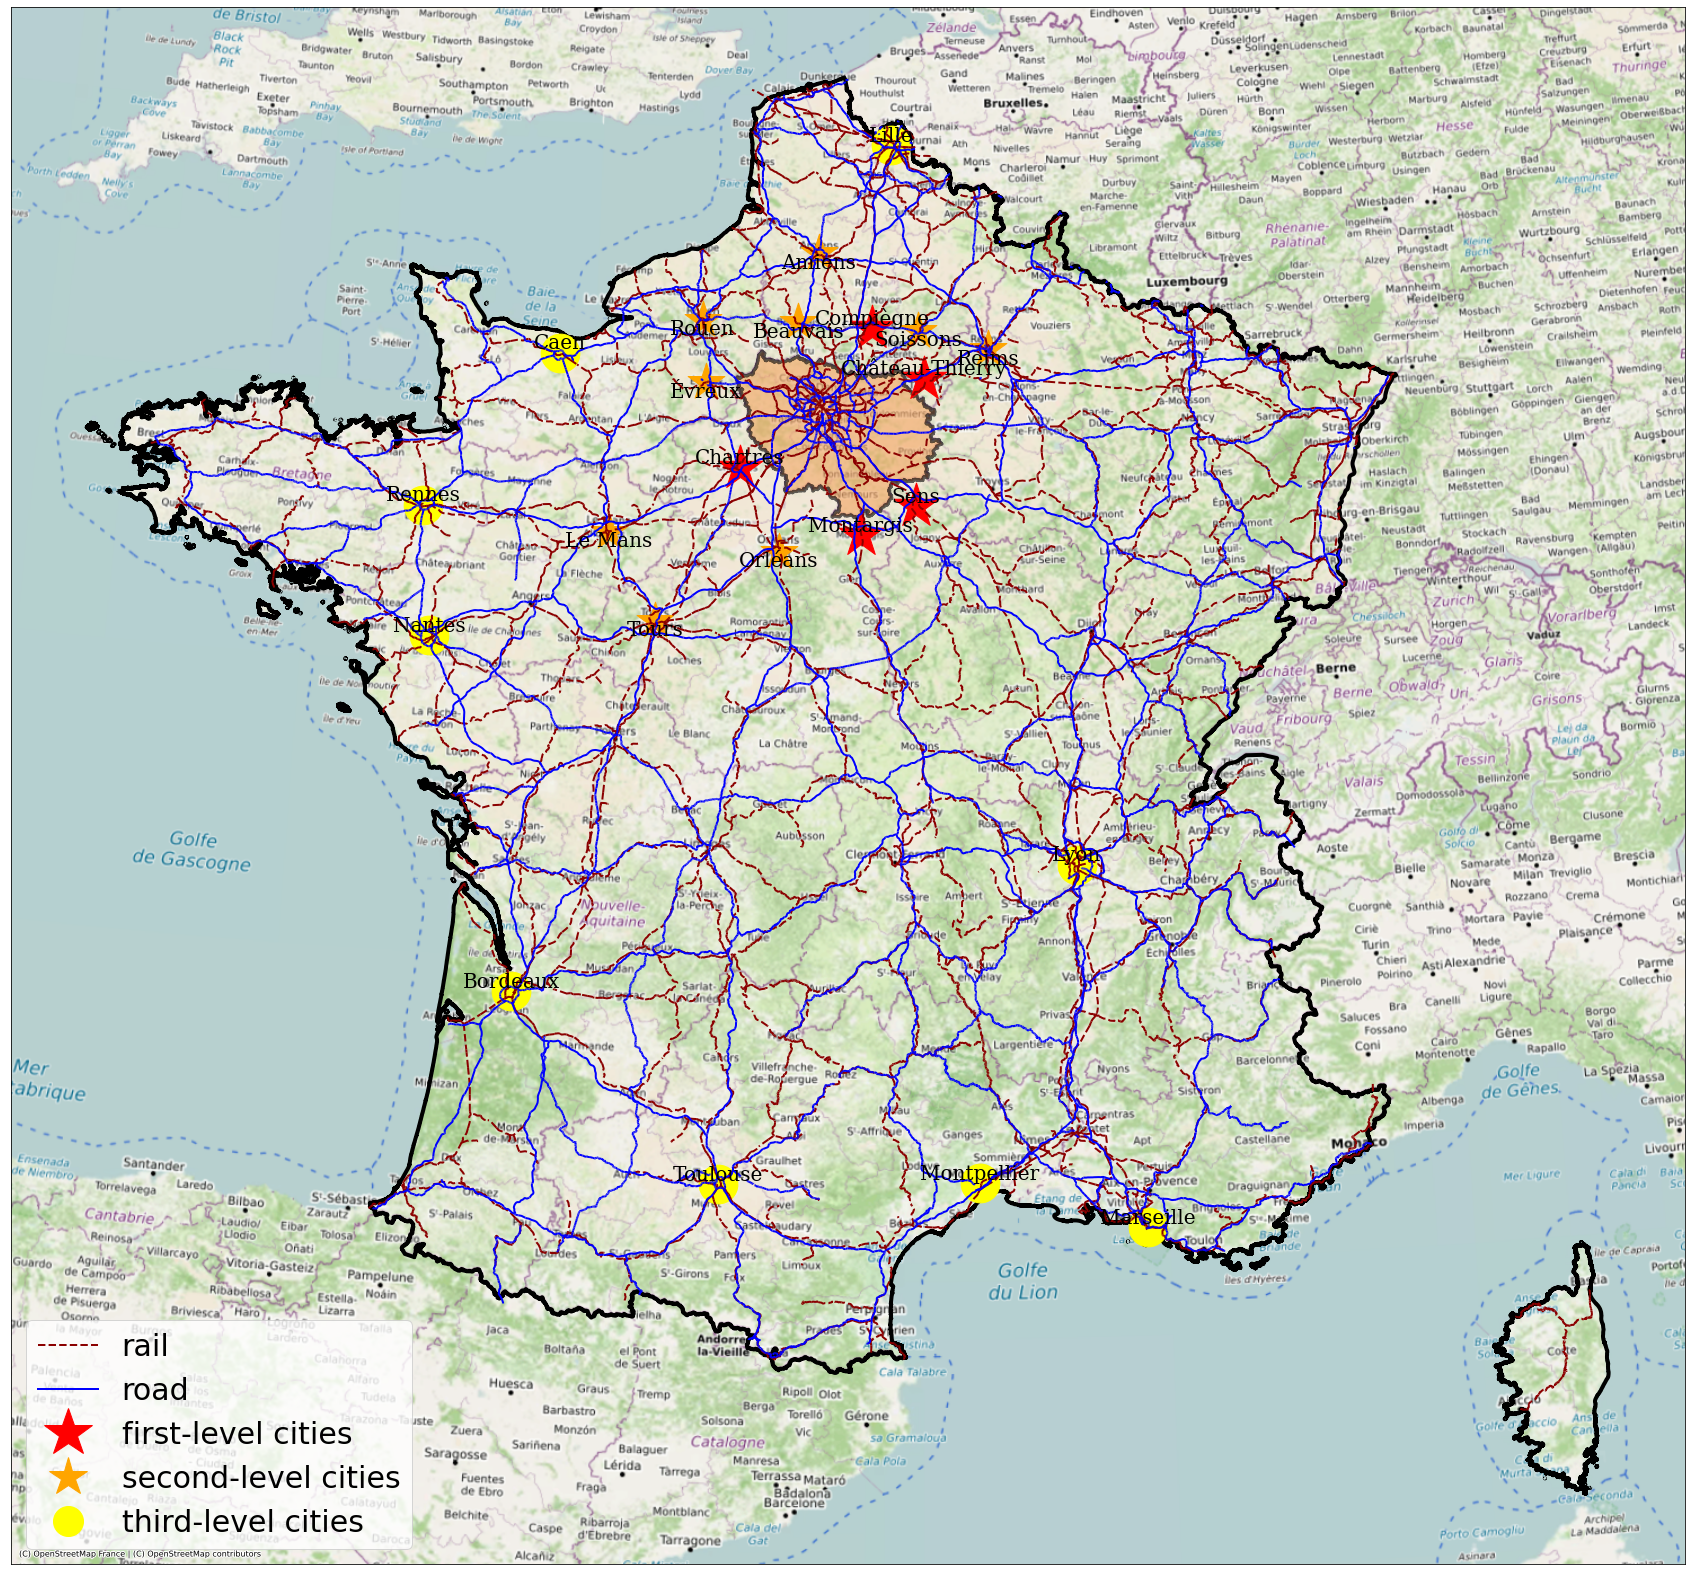

In [124]:
fig, ax = plt.subplots(figsize=(30,30))
ax.set_xticks([])
ax.set_yticks([])

France_entier.plot(ax=ax,facecolor="none",edgecolor="k",linewidth=4, alpha = 1)
IDF.plot(ax=ax,color='sandybrown',alpha=0.6,edgecolor="k",linewidth=3)

rail.plot(ax=ax, color='darkred',linestyle='dashed', linewidth = 2)
#LGV.plot(ax=ax, color='red',linestyle='solid', linewidth = 5)

road_prin.plot(ax=ax, color='blue',linestyle='solid', linewidth = 2)

ville_prin_1.plot(ax=ax, color='red',markersize=2200, marker = '*')
ville_prin_1.apply(lambda x: ax.annotate(text=x['nom'], xy=x.geometry.centroid.coords[0], va='bottom',ha='center',fontsize=20,family = 'serif',
                                      color='k',), axis=1);

ville_prin_2.plot(ax=ax, color='orange',markersize=1500, marker = '*')
ville_prin_2.apply(lambda x: ax.annotate(text=x['nom'], xy=x.geometry.centroid.coords[0], va='top',ha='center',fontsize=20,family = 'serif',
                                      color='k',), axis=1);

ville_prin_3.plot(ax=ax, color='yellow',markersize=1500, marker = 'o')
ville_prin_3.apply(lambda x: ax.annotate(text=x['nom'], xy=x.geometry.centroid.coords[0], va='bottom', ha='center',fontsize=20,family = 'serif',
                                      color='k',), axis=1);


cx.add_basemap(ax,crs=rail.crs,source=cx.providers.OpenStreetMap.France)

#legend
rail_rec = Line2D([0], [0], color='darkred', label='rail',linestyle='dashed',markersize=50, markeredgewidth=100, linewidth=2)
road_rec = Line2D([0], [0], color='blue', label='road',linestyle='solid',markersize=50, markeredgewidth=100, linewidth=2)

red_star = mlines.Line2D([], [], color='red', marker='*', linestyle='None',markersize=50, label='first-level cities')
orange_star = mlines.Line2D([], [], color='orange', marker='*', linestyle='None',markersize=40, label='second-level cities')
yellow_circle = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',markersize=30, label='third-level cities')

plt.legend(handles=[rail_rec ,road_rec,red_star,orange_star,yellow_circle ],fontsize=30,loc=3)

In [125]:
fig.savefig('C:/Users/kangl/Desktop/CSMM/map_attraction.jpg')

# different map providers with their different styles of maps

In [119]:
cx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://{s}.tile.openstreetmap.de/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'BlackAndWhite': {'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'name': 'OpenStreetMap.BlackAndWhite'}},
 'OpenSeaMap': {'url': 'https://tiles.openseamap.org/seamark/{z}/{x}/{y}.png',
  'html_attribution': 'Map data: &copy; <a href="http://www.openseamap.org">OpenSeaMap</a> contributors',
  'attribution': 'Map data: (C) OpenSeaMap contributors',
  'name': 'OpenSeaMap'},
 'OPNVKarte': {'url': 'https://tileserver.memomaps.de/tilegen/{z}/{x}/{y}.png',
  'max_zoom': 18,
  'html_attribution': 'Map <a href="https://memomaps.de/">memomaps.de</a> <a href="http://creativecommons.org/licenses/by-sa/2.0/">CC-BY-SA</a>, map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
  'attribution': 'Map memomaps.de CC-BY-SA, map data (C) OpenStreetMap contributors',
  'name': 'OPNVKarte'},
 'OpenTopoMap': {'url': 'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
  'max_zoom': 17,
  'html_attribution': 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
  'attribution': 'Map data: (C) OpenStreetMap contributors, SRTM | Map style: (C) OpenTopoMap (CC-BY-SA)',
  'name': 'OpenTopoMap'},
 'OpenRailwayMap': {'url': 'https://{s}.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png',
  'max_zoom': 19,
 